# Constructing dataset of fire incidences and their environmental predictors

Author: Jatan Buch (v1, 231120) || (v2, 231201) || (v3, 231210)


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
import re # for regular expressions

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray
import zarr
import xesmf as xe # for regridding
import pickle # for saving and loading models
from pathlib import Path

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# self-libraries
from data_utils import *

from shapely.geometry import Point, mapping, LineString
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

# Environmental predictors

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

sub = (51.6, -128, 26.5, -101) # North/West/South/East
ds_out = xarray.Dataset(
    {
        "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
    }
)

## Vegetation data

In [3]:
casm_ds= xarray.open_dataset('../data/vegetation/casm_for_jatan.nc') #, chunks={"date": 10}

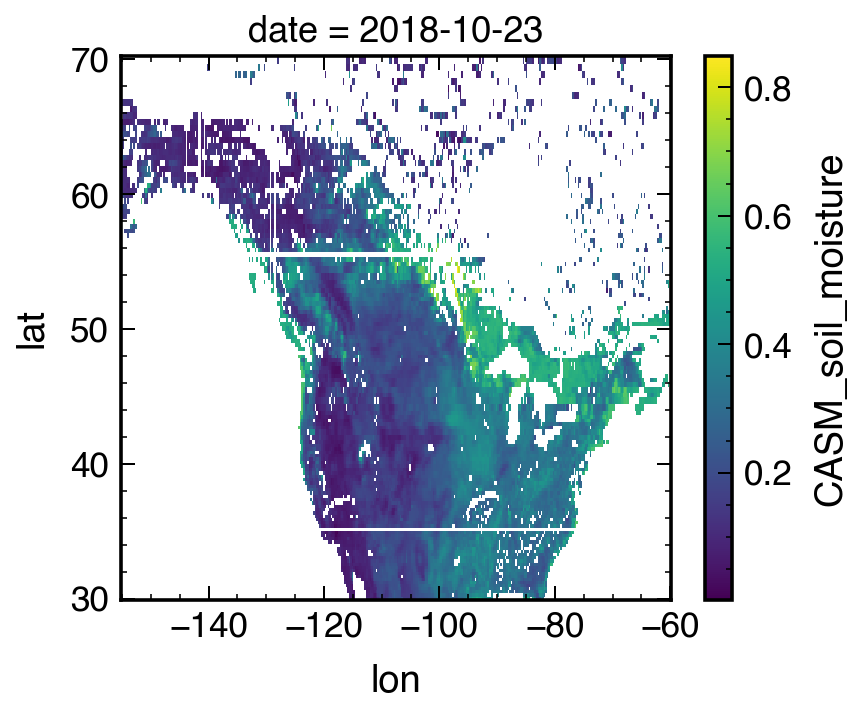

In [71]:
casm_ds.CASM_soil_moisture[1983].plot()

In [4]:
casm_ds_conus_XY= regridding_func(casm_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#casm_ds_conus_XY.to_netcdf('../data/12km/casm_conus_12km.nc')

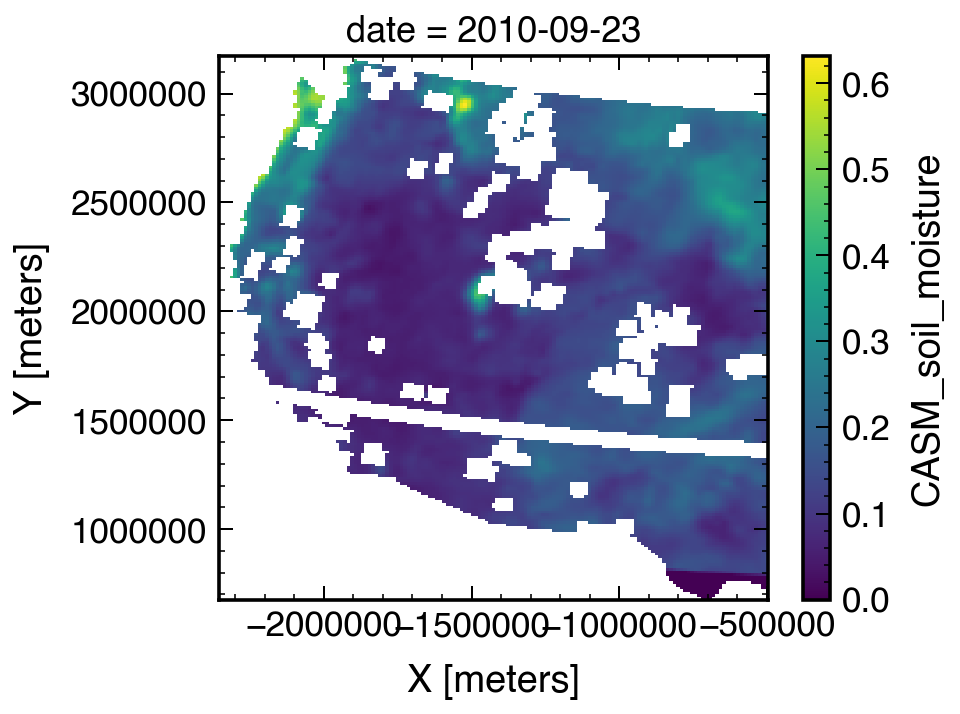

In [5]:
casm_ds_conus_XY.CASM_soil_moisture[1000].plot()

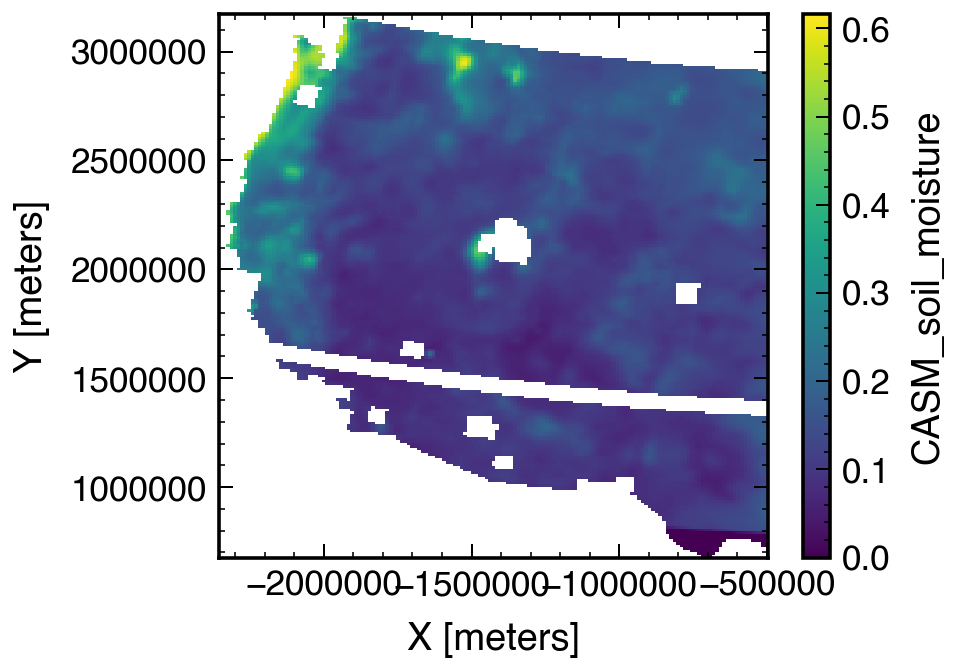

In [64]:
casm_ds_conus_XY.CASM_soil_moisture.mean(dim= 'date').plot()

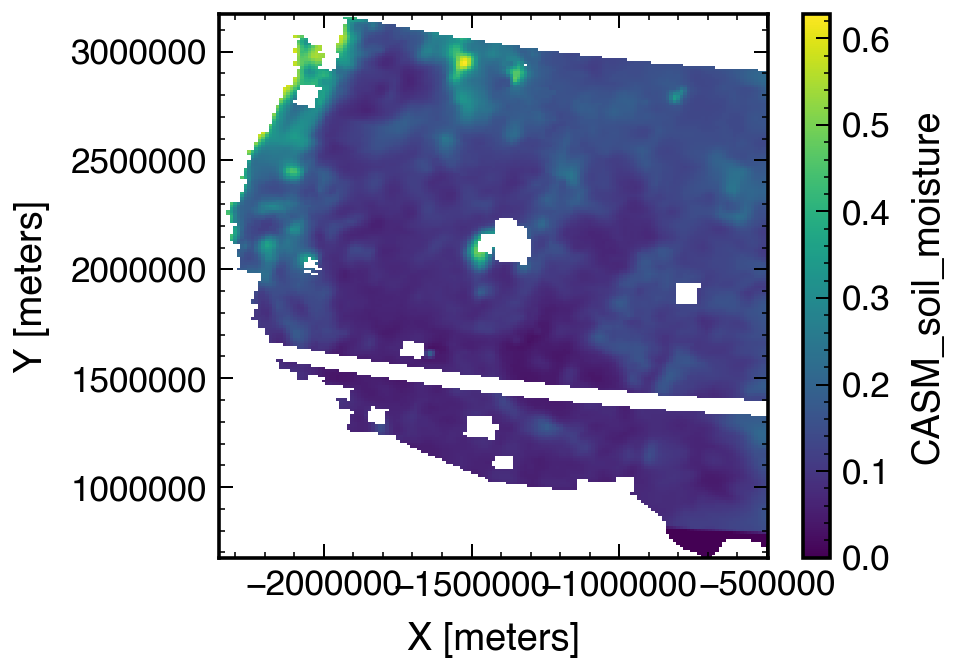

In [67]:
casm_ds_conus_XY.CASM_soil_moisture.sel(date= casm_ds_conus_XY.date.dt.month == 6).mean(dim= 'date').plot()

In [7]:
csif_ds= xarray.open_dataset('../data/vegetation/csif_for_jatan.nc')

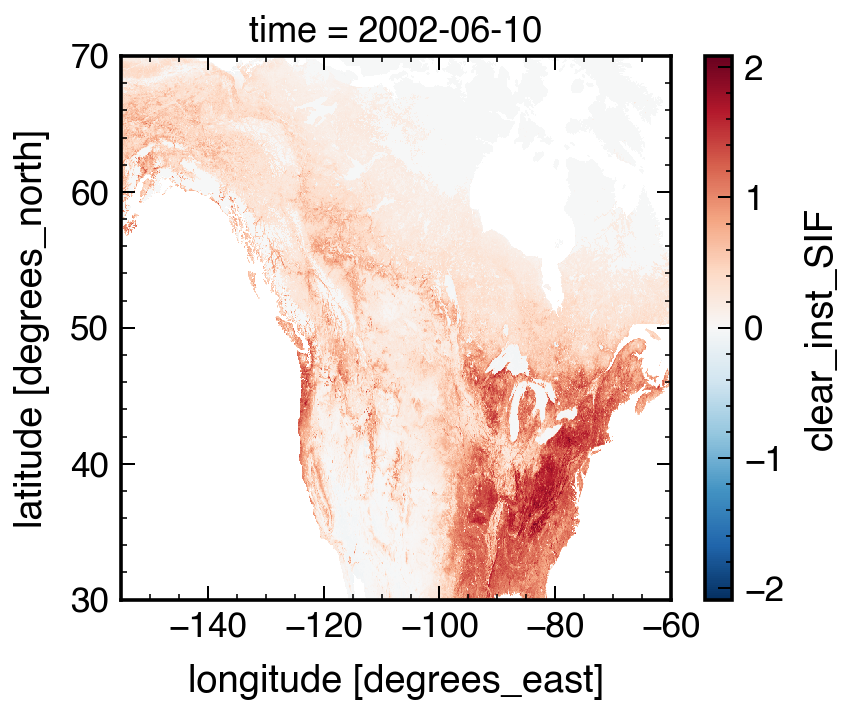

In [9]:
csif_ds.clear_inst_SIF[40].plot()

In [10]:
csif_ds_conus_XY= regridding_func(csif_ds.clear_inst_SIF, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear')
#csif_ds_conus_XY.to_netcdf(''../data/12km/csif_clear_inst_conus_12km.nc')

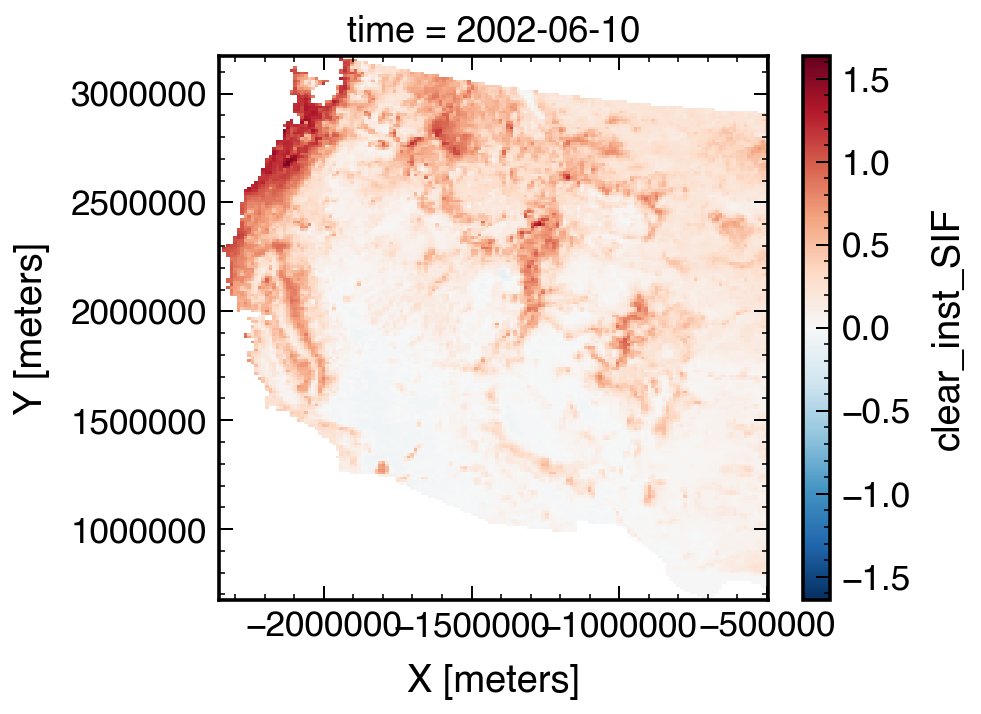

In [11]:
csif_ds_conus_XY[40].plot()

## ERA5 reanalysis data

(Used instead of gridMET for future compatability with Canadian/Australian data as well)

In [3]:
DATADIR = '../data/meteorology'
var_arr= ['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation', '10m_u_component_of_wind', '10m_v_component_of_wind']
yr_arr= list(np.arange(2021, 2025).astype(str)) #list(np.arange(2002, 2021).astype(str))

### Hourly data

In [ ]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '7f500c4b-837e-4f89-8c3d-e3bd829683c0'

In [10]:
c = cdsapi.Client(url=URL, key=KEY)
for var in var_arr:
    for yr in yr_arr:
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'grib',
                'variable': [var],
                'year': [yr],
                'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30',
                    '31',
                ],
                'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
                'area': [51.6, -128, 26.5, -101],
            },
            f'{DATADIR}/hourly/era5_wus_forecast_hourly_%s'%var + f'_%s.grib'%yr)

2025-04-04 22:07:59,306 WARNING [2025-04-03T00:00:00] System is in degraded status due to issues on the underlaying infrastructure. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/data-stores-in-degraded-status/12472)
2025-04-04 22:07:59,307 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-04 22:07:59,307 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-04 22:07:59,960 INFO Request ID is f5a0b0d0-bf06-4487-ae1a-1c97d469d9d0
2025-04-04 22:08:00,118 INFO status has been updated to accepted
2025-04-04 22:08:05,325 INFO status has been updated to running
2025-04-04 22:18:21,625 INFO status has been updated to successful
2025-04-

In [20]:
ds= xarray.open_dataset(f'{DATADIR}hourly/era5_wus_forecast_hourly_2m_temperature_2002.grib', engine='cfgrib')

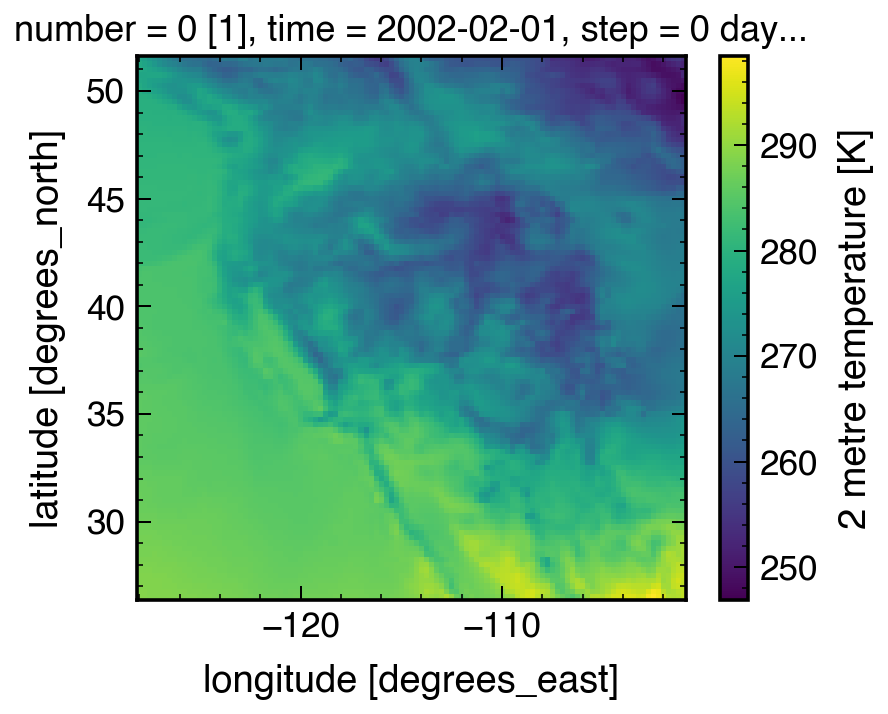

In [27]:
ds.t2m[0].plot()

### Daily data

#### Load data

In [ ]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '7f500c4b-837e-4f89-8c3d-e3bd829683c0'

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)
for yr in yr_arr:
    c.retrieve(
        'cems-fire-historical-v1',
        {
            'product_type': 'reanalysis',
            'format': 'grib',
            'variable': 'fire_weather_index',
            'year': [yr],
            'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'grid': '0.25/0.25',
            'area': [51.6, -128, 26.5, -101],
        },
        f'{DATADIR}/daily/era5_wus_forecast_daily_ffwi_%s.grib'%yr)

In [29]:
ffwi_da= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_FFWI_2002-2020.nc')

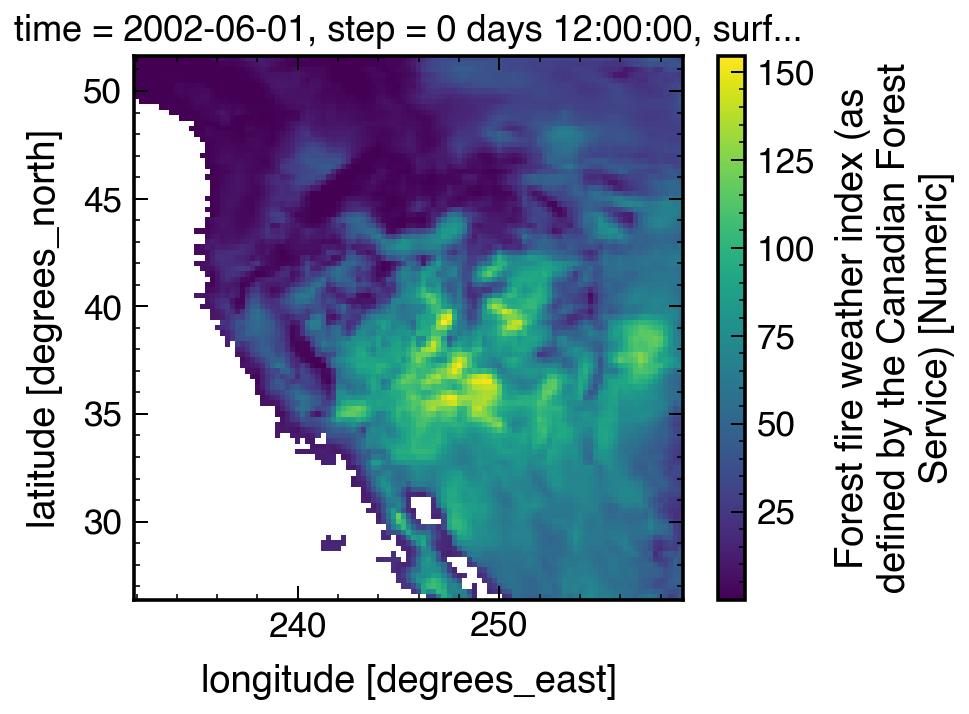

In [32]:
ffwi_da[120].plot()

#### Process data

In [ ]:
load_daily_meteorlogical_predictors(var= '2m_temperature', yrarr= yr_arr, datadir= DATADIR, maxmin_arg= 'max')
load_daily_meteorlogical_predictors(var= '2m_temperature', yrarr= yr_arr, datadir= DATADIR, maxmin_arg= 'min')
load_daily_meteorlogical_predictors(var= '2m_dewpoint_temperature', yrarr= yr_arr, datadir= DATADIR)
load_daily_meteorlogical_predictors(var= 'total_precipitation', yrarr= yr_arr, datadir= DATADIR)

100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


In [ ]:
ds_tmax= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Tmax_2021-2024.nc')
ds_tmin= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Tmin_2021-2024.nc')
ds_tavg= (ds_tmax + ds_tmin)/2
ds_tdew= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Tdew_2021-2024.nc')

In [28]:
ds_vpd= vapor_pressure(ds_tavg) - vapor_pressure(ds_tdew)
#update the variable name and attributes
ds_vpd.name= 'VPD'
ds_vpd.attrs['units']= 'hPa'
ds_vpd.attrs['description']= 'Vapor Pressure Deficit'

ds_vpd.to_netcdf(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_VPD_2021-2024.nc')

### Regridded data

In [34]:
tmax_ds= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Tmax_2021-2024.nc')
tmax_ds_conus_XY= regridding_func(tmax_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmax_ds_conus_XY.to_netcdf('../data/12km/daily/Tmax_daily_conus_2021-2024_12km.nc')

tmin_ds= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Tmin_2021-2024.nc')
tmin_ds_conus_XY= regridding_func(tmin_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmin_ds_conus_XY.to_netcdf('../data/12km/daily/Tmin_daily_conus_2021-2024_12km.nc')

prec_ds= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_Prec_2021-2024.nc')
prec_ds_conus_XY= regridding_func(prec_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
prec_ds_conus_XY.to_netcdf('../data/12km/daily/Prec_daily_conus_2021-2024_12km.nc')

vpd_ds= xarray.open_dataarray(f'{DATADIR}/daily_2021_2024/era5_wus_forecast_daily_VPD_2021-2024.nc')
vpd_ds_conus_XY= regridding_func(vpd_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
vpd_ds_conus_XY.to_netcdf('../data/12km/daily/VPD_daily_conus_2021-2024_12km.nc')

# ffwi_ds= xarray.open_dataarray(f'{DATADIR}/daily/era5_wus_forecast_daily_FFWI_2002-2020.nc')
# ffwi_ds_conus_XY= regridding_func(ffwi_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
# ffwi_ds_conus_XY= ffwi_ds_conus_XY.drop(['valid_time', 'step', 'surface'])
# ffwi_ds_conus_XY.to_netcdf('../data/12km/FFWI_daily_conus_2002-2020_12km.nc')

In [ ]:
tmax_hourly_ds= xr.open_mfdataset(f'{DATADIR}/hourly/era5_wus_forecast_hourly_2m_temperature_*.grib', engine='cfgrib')
tmax_hourly_ds_conus_XY= regridding_func(tmax_hourly_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tmax_hourly_ds_conus_XY= tmax_hourly_ds_conus_XY.drop(['number', 'valid_time', 'step', 'surface'])
tmax_hourly_ds_conus_XY.to_netcdf(f'{DATADIR}/hourly/T2m_hourly_conus_2021-2024_12km.nc')

In [51]:
tdew_hourly_ds= xr.open_mfdataset(f'{DATADIR}/hourly/era5_wus_forecast_hourly_2m_dewpoint_temperature_*.grib', engine='cfgrib')
tdew_hourly_ds_conus_XY= regridding_func(tdew_hourly_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
tdew_hourly_ds_conus_XY= tdew_hourly_ds_conus_XY.drop(['number', 'valid_time', 'step', 'surface'])
tdew_hourly_ds_conus_XY.to_netcdf(f'{DATADIR}/hourly/Tdew_hourly_conus_2021-2024_12km.nc')

In [52]:
prec_hourly_ds= xr.open_mfdataset(f'{DATADIR}/hourly/era5_wus_forecast_hourly_total_precipitation_*.grib', engine='cfgrib')
prec_hourly_ds_conus_XY= regridding_func(prec_hourly_ds, subarea= sub, dsout= ds_out, regrid_scheme= 'bilinear', latname= 'latitude', lonname= 'longitude')
prec_hourly_ds_conus_XY= prec_hourly_ds_conus_XY.drop(['number', 'valid_time', 'surface'])
prec_hourly_ds_conus_XY.to_netcdf(f'{DATADIR}/hourly/Prec_hourly_conus_2021-2024_12km.nc')

In [ ]:
es_hourly_ds= vapor_pressure(tmax_hourly_ds_conus_XY)
ea_hourly_ds= vapor_pressure(tdew_hourly_ds_conus_XY)
vpd_hourly_ds= es_hourly_ds['t2m'] - ea_hourly_ds['d2m']
vpd_hourly_ds.to_netcdf(f'{DATADIR}/hourly/VPD_hourly_conus_2021-2024_12km.nc')

In [71]:
vpd_hourly_ds= es_hourly_ds['t2m'] - ea_hourly_ds['d2m']
vpd_hourly_ds.to_netcdf(f'{DATADIR}/hourly/VPD_hourly_conus_2021-2024_12km.nc')

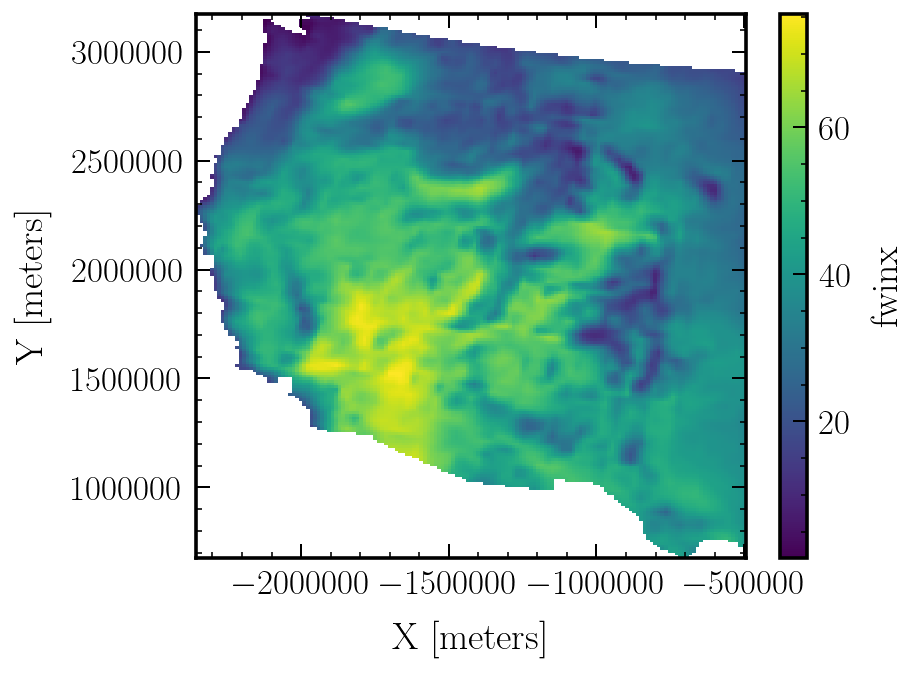

In [10]:
ffwi_da= xarray.open_dataarray('../data/12km/FFWI_daily_conus_2002-2020_12km.nc')
ffwi_da.sel(time= ffwi_da.time.dt.month.isin([6, 7, 8])).mean(dim= 'time').plot()

# Fire perimeters

In [3]:
# Although both gpkg and shapefiles are provided, we will use the gpkg files as they contain all the information in one place

# fire_gdf= gpd.read_file('../data/fire/fired_conus-ak_nov2001-march2021/fired_conus-ak_daily_nov2001-march2021.gpkg')
# eventsdf= fire_gdf.to_crs('5070')

# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([1, 2, 3, 4, 5, 8])].to_file('../data/fire/fired_conus-ak_2002-2021_forests.gpkg', driver='GPKG')
# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([6, 7])].to_file('../data/fire/fired_conus-ak_2002-2021_shrubland.gpkg', driver='GPKG')
# eventsdf[eventsdf.ig_year > 2001][eventsdf.lc_mode.isin([9, 10])].to_file('../data/fire/fired_conus-ak_2002-2021_grassland.gpkg', driver='GPKG')

In [2]:
forests_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_forests.gpkg')
shrubland_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_shrubland.gpkg')
grassland_gdf= gpd.read_file('../data/fire/fired_conus-ak_2002-2021_grassland.gpkg')

## CONUS BA summary plot

In [18]:
forest_xarr_ur= xarray.open_dataarray('../data/12km/forest_burned_area_2002-2021_12km.nc')
forest_xarr= forest_xarr_ur.sel(time= forest_xarr_ur.time.isin(pd.date_range(start= '2002-06-19', end= '2020-10-01', freq= 'D')))
forest_df= forest_xarr.to_dataframe('fire').reset_index()

ind_wf= 105739853 
ind_acf= 214182885
wf_lon, wf_lat= coord_transform([forest_df.loc[ind_wf].X], [forest_df.loc[ind_wf].Y], 'epsg:5070', 'epsg:4326')
acf_lon, acf_lat= coord_transform([forest_df.loc[ind_acf].X], [forest_df.loc[ind_acf].Y], 'epsg:5070', 'epsg:4326')

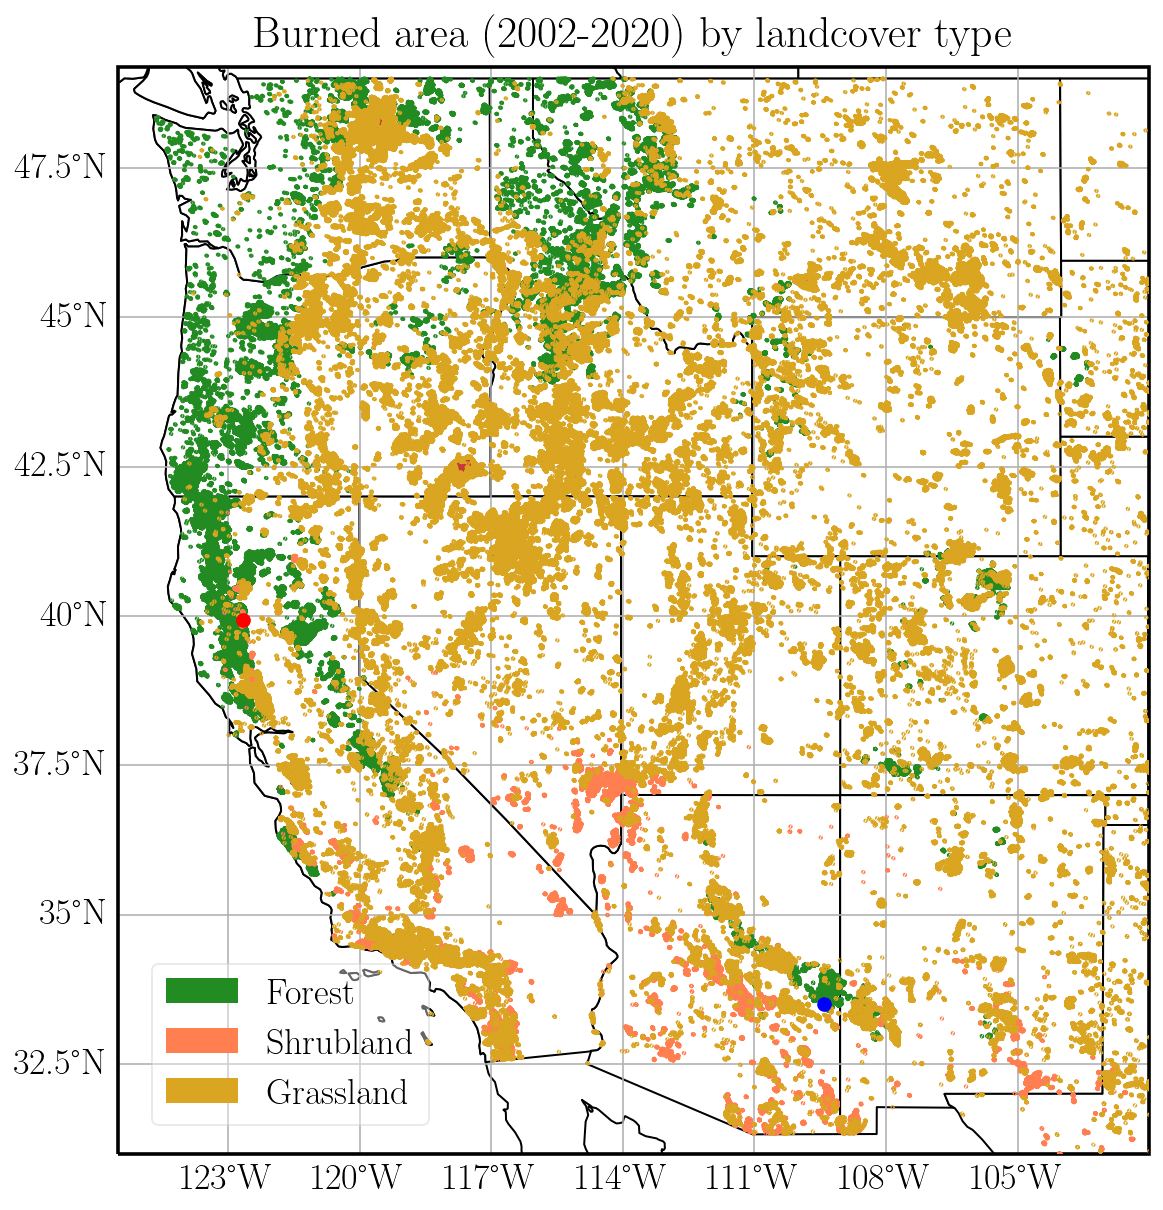

In [33]:
extent = [-125.5, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', facecolor= 'white', zorder= 1);
ax.add_geometries(forests_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('forestgreen', alpha= 1.0), lw= 2, zorder= 10)
ax.add_geometries(shrubland_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('coral', alpha= 1.0), lw= 2, zorder= 10)
ax.add_geometries(grassland_gdf.geometry.to_crs('4326'), crs= ccrs.PlateCarree(), edgecolor= colors.to_rgba('goldenrod', alpha= 1.0), lw= 2, zorder= 10)

ax.scatter(wf_lon[0], wf_lat[0], c= 'blue', s= 40, transform=ccrs.PlateCarree(), zorder= 20)
ax.scatter(acf_lon[0], acf_lat[0], c= 'red', s= 40, transform=ccrs.PlateCarree(), zorder= 20)

ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False

forest_leg = patches.Rectangle((0, 0), 1, 1, facecolor="forestgreen")
shrub_leg = patches.Rectangle((0, 0), 1, 1, facecolor="coral")
grass_leg = patches.Rectangle((0, 0), 1, 1, facecolor="goldenrod")
labels = ['Forest', 'Shrubland', 'Grassland']
ax.legend([forest_leg, shrub_leg, grass_leg], labels, loc='lower left', bbox_to_anchor=(0.015, 0.01), fontsize= 18, frameon=True)

ax.set_aspect(1.362/1)
ax.set_title(r'Burned area (2002-2020) by landcover type', fontsize= 22, pad= 10);
#plt.savefig('../plots/ba_conus_2002-2020.png', bbox_inches='tight', dpi= 200);

## Rasterizing daily BA perimeters

In [3]:
# init_fire_counts_raster(start_date= '2002-01-01', end_date= '2021-05-01', sav_flag= True) # for intializing the raster

# convert ignition date into number of days since 2002-01-01
forests_gdf['ig_day']= (pd.to_datetime(forests_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
forests_gdf['event_ig_day'] = forests_gdf['event_day'] + forests_gdf['ig_day'] - 1
grassland_gdf['ig_day']= (pd.to_datetime(grassland_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
grassland_gdf['event_ig_day'] = grassland_gdf['event_day'] + grassland_gdf['ig_day'] - 1
shrubland_gdf['ig_day']= (pd.to_datetime(shrubland_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
shrubland_gdf['event_ig_day'] = shrubland_gdf['event_day'] + shrubland_gdf['ig_day'] - 1

In [4]:
shrubland_xarr, _= init_fire_alloc_gdf(lcgdf= shrubland_gdf, lctype= 'shrubland', sav_flag= True)
forest_xarr, _= init_fire_alloc_gdf(lcgdf= forests_gdf, lctype= 'forest', sav_flag= True)
grassland_xarr, _= init_fire_alloc_gdf(lcgdf= grassland_gdf, lctype= 'grassland', sav_flag= True)

100%|██████████| 90539/90539 [01:02<00:00, 1443.00it/s]


# Data analysis

In [3]:
firemons_arr= np.array([2, 3, 4, 5, 6, 7, 8, 9])

sm_data_ur= xarray.open_dataset('../data/12km/casm_conus_12km.nc').CASM_soil_moisture
sm_data= sm_data_ur.sel(date = sm_data_ur.date.dt.month.isin(firemons_arr))
sm_data= sm_data.interpolate_na(dim= 'date', fill_value= 'extrapolate') # interpolating missing values

csif_data_ur= xarray.open_dataarray('../data/12km/csif_clear_inst_conus_12km.nc')
csif_data= csif_data_ur.sel(time = csif_data_ur.time.dt.month.isin(firemons_arr)).interp(time= sm_data.date.values)

tmax_data= xarray.open_dataarray('../data/12km/Tmax_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
tmin_data= xarray.open_dataarray('../data/12km/Tmin_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
prec_data= xarray.open_dataarray('../data/12km/Prec_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 
vpd_data= xarray.open_dataarray('../data/12km/VPD_daily_conus_2002-2020_12km.nc').resample(time= '3D').mean().sel(time= sm_data.date.values) 

In [4]:
forest_xarr_ur= xarray.open_dataarray('../data/12km/forest_burned_area_2002-2021_12km.nc')
grassland_xarr_ur= xarray.open_dataarray('../data/12km/grassland_burned_area_2002-2021_12km.nc')
shrubland_xarr_ur= xarray.open_dataarray('../data/12km/shrubland_burned_area_2002-2021_12km.nc')

### Fire growth animation

In [5]:
forest_xarr= forest_xarr_ur.sel(time= forest_xarr_ur.time.isin(pd.date_range(start= '2002-06-19', end= '2020-10-01', freq= 'D')))
forest_df= forest_xarr.to_dataframe('fire').reset_index()
forest_df['tot_days']= (forest_df.time - pd.to_datetime('2002-01-01')).dt.days

In [6]:
forests_gdf['ig_day']= (pd.to_datetime(forests_gdf['ig_date']) - pd.to_datetime('2002-01-01')).dt.days
forests_gdf['event_ig_day'] = forests_gdf['event_day'] + forests_gdf['ig_day'] - 1

In [49]:
forests_gdf.sort_values(by= 'tot_ar_km2', ascending= False)[['id', 'ig_day', 'event_ig_day', 'dy_ar_km2', 'tot_ar_km2', 'geometry']][0:].head(20)

,id,ig_day,event_ig_day,dy_ar_km2,tot_ar_km2,geometry
97284,429894,6801,6833,78.135757,3503.873524,"MULTIPOLYGON (((-2269576.811 2152815.833, -227..."
97267,429894,6801,6816,51.518082,3503.873524,"MULTIPOLYGON (((-2260711.088 2149747.445, -226..."
97289,429894,6801,6838,14.167472,3503.873524,"MULTIPOLYGON (((-2263299.786 2149527.570, -226..."
97288,429894,6801,6837,13.094179,3503.873524,"MULTIPOLYGON (((-2269135.108 2152686.929, -226..."
97287,429894,6801,6836,28.764262,3503.873524,"MULTIPOLYGON (((-2264889.130 2147072.078, -226..."
97286,429894,6801,6835,36.921292,3503.873524,"MULTIPOLYGON (((-2266894.333 2151547.023, -226..."
97253,429894,6801,6801,0.858635,3503.873524,"MULTIPOLYGON (((-2239607.012 2159194.916, -223..."
97254,429894,6801,6802,1.717269,3503.873524,"MULTIPOLYGON (((-2246757.279 2169036.974, -224..."
97255,429894,6801,6804,26.617675,3503.873524,"MULTIPOLYGON (((-2244814.740 2159239.800, -224..."
97256,429894,6801,6805,55.167279,3503.873524,"MULTIPOLYGON (((-2244406.435 2159607.875, -224..."


In [46]:
forest_df[forest_df.fire > 0][forest_df.tot_days == 6826].sort_values(by= 'fire', ascending= False).head(20)

,time,Y,X,fire,tot_days
214627439,2020-09-09,2722500.0,-2061250.0,39.651085,6826
214628521,2020-09-09,2638500.0,-2097250.0,32.222975,6826
214628520,2020-09-09,2638500.0,-2109250.0,26.228952,6826
214627283,2020-09-09,2734500.0,-2073250.0,25.543671,6826
214627905,2020-09-09,2686500.0,-2049250.0,25.083733,6826
214627438,2020-09-09,2722500.0,-2073250.0,24.208206,6826
214627751,2020-09-09,2698500.0,-2037250.0,23.409786,6826
214627907,2020-09-09,2686500.0,-2025250.0,22.068363,6826
214627286,2020-09-09,2734500.0,-2037250.0,20.672101,6826
214634243,2020-09-09,2194500.0,-2253250.0,19.588878,6826


MovieWriter PillowWriter unavailable; using Pillow instead.


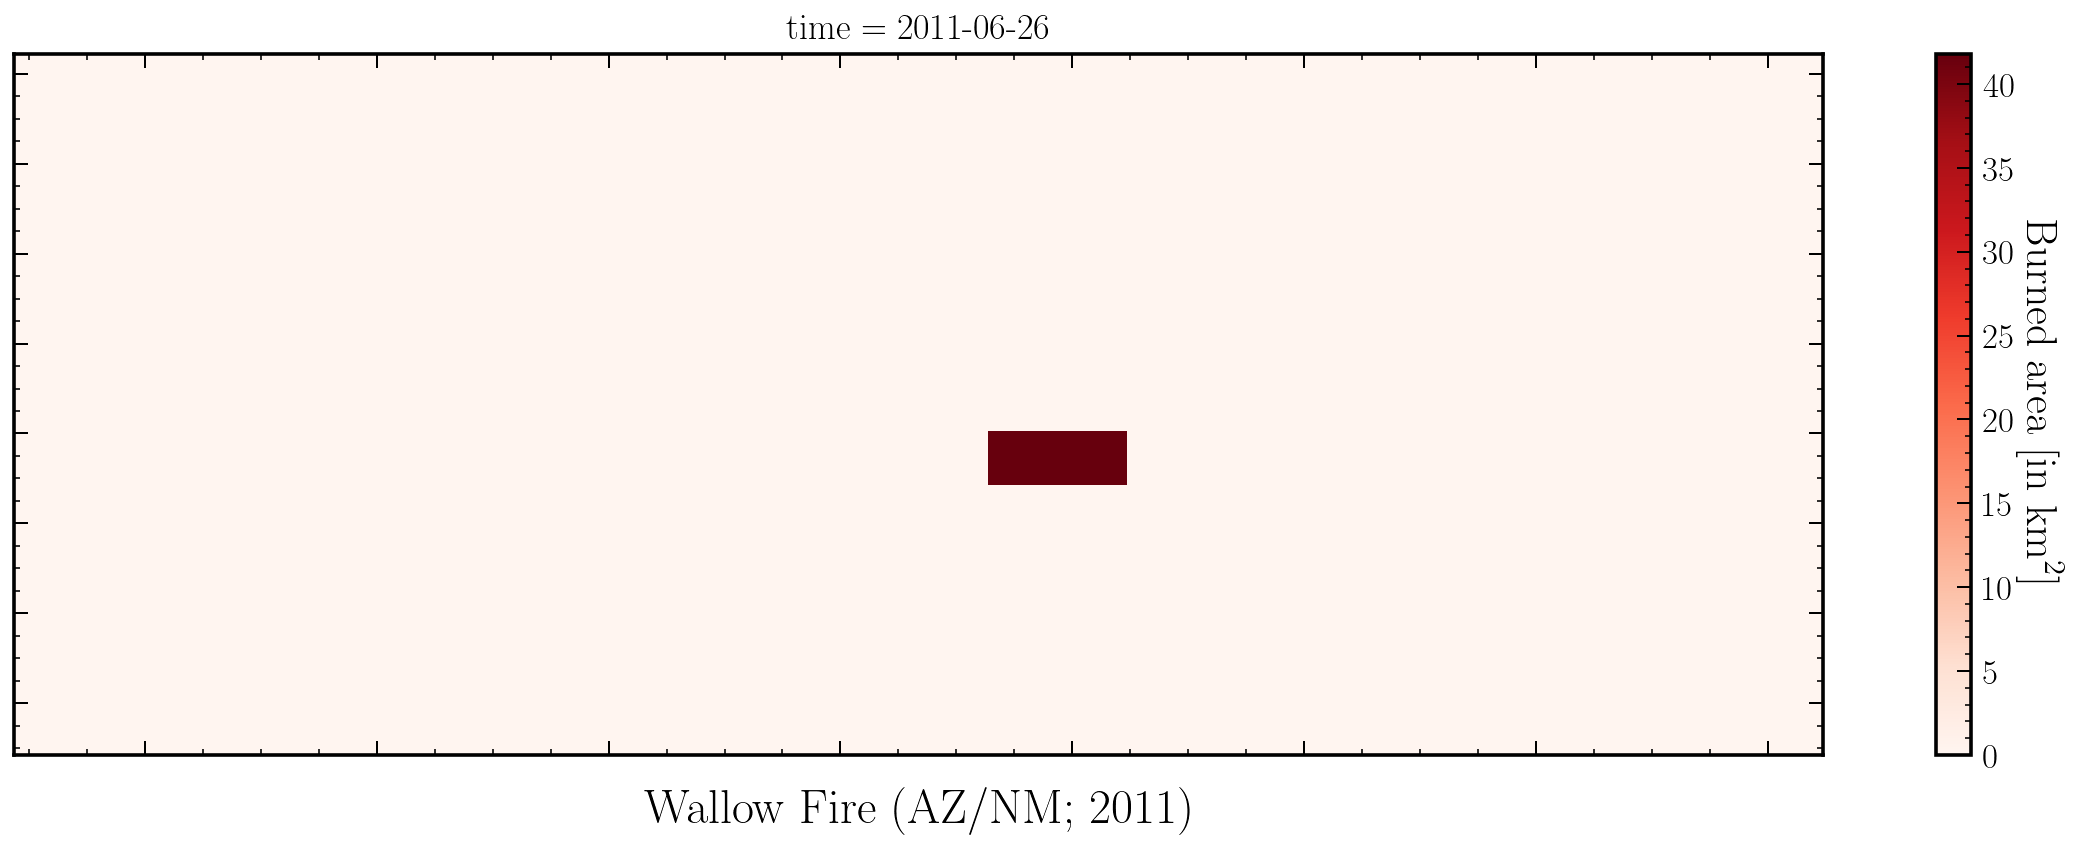

In [53]:
ind= 105739853 #wf1: 105739853 #acf2: 214182885 #acf1: 213957050 
n_grid = 7
cellwidth= 12000
days_arr = np.arange(-5, 16, 1, dtype=float) #acf2: np.arange(-5, 25, 1, dtype=float) #wf1: np.arange(-5, 16, 1, dtype=float)

fig, ax = plt.subplots(figsize=(16, 6), tight_layout=True)

# Create a dummy plot for the colorbar
subset = forest_xarr.sel(time=forest_df.loc[ind].time + timedelta(days=days_arr[0]), 
                         Y=(forest_xarr.Y < forest_df.loc[ind].Y + n_grid*cellwidth) & (forest_xarr.Y > forest_df.loc[ind].Y - n_grid*cellwidth), 
                         X=(forest_xarr.X < forest_df.loc[ind].X + n_grid*cellwidth) & (forest_xarr.X > forest_df.loc[ind].X - n_grid*cellwidth), method= 'nearest')
im = subset.plot(ax=ax, cmap=plt.cm.Reds, add_colorbar=False)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel(ylabel= r'Burned area [in ${\rm km}^2$]', rotation= 270, labelpad= 25, fontsize= 22)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')

# Define the update function
def update(day):
    ax.clear()
    subset = forest_xarr.sel(time=forest_df.loc[ind].time + timedelta(days=day), 
                             Y=(forest_xarr.Y < forest_df.loc[ind].Y + n_grid*cellwidth) & (forest_xarr.Y > forest_df.loc[ind].Y - n_grid*cellwidth), 
                             X=(forest_xarr.X < forest_df.loc[ind].X + n_grid*cellwidth) & (forest_xarr.X > forest_df.loc[ind].X - n_grid*cellwidth), method= 'nearest')
    im = subset.plot(ax=ax, cmap=plt.cm.Reds, add_colorbar=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('Wallow Fire (AZ/NM; 2011)', fontsize= 24) #ax.set_xlabel('Wallow Fire (AZ/NM; 2011)') #ax.set_xlabel('August Complex Fire (CA; 2020)')
    ax.set_ylabel('')
    #ax.tick_params(labeltop= True, top=True, labelright=False, right=True, which='both', labelsize= 30);
    return im,

# Create the animation
ani = FuncAnimation(fig, update, frames=days_arr, repeat=False, blit=True)
#HTML(ani.to_html5_video())
ani.save('../plots/wallowfire_animation.gif', writer='PillowWriter', fps= 2, dpi= 300) #augcompfire

### Timeseries modeling

In [ ]:
forest_xarr= forest_xarr_ur.sel(time= forest_xarr_ur.time.isin(pd.date_range(start= '2002-06-19', end= '2020-09-01', freq= 'D'))).resample(time= '3D').sum().sel(time= sm_data.date.values)
forest_df= forest_xarr.to_dataframe('fire').reset_index()

Text(0, 0.5, 'Burned area (in ${\\rm km}^2$)')

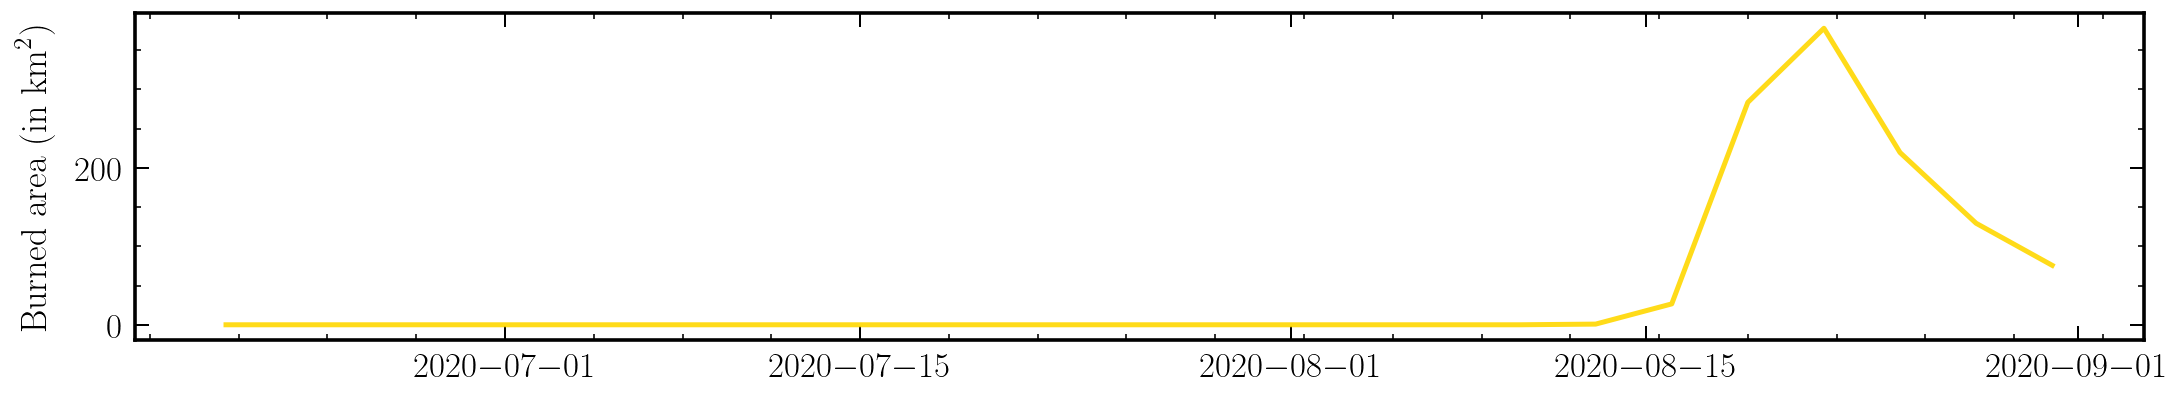

In [33]:
ind= 47308644 #47308644
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 18), periods= 25, freq= '3D').values, \
                    forest_xarr.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 18), periods= 25, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X).values, color= 'gold')
ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 18)
#plt.savefig('../plots/fire_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'Soil moisture ($m^3 /m^3$)')

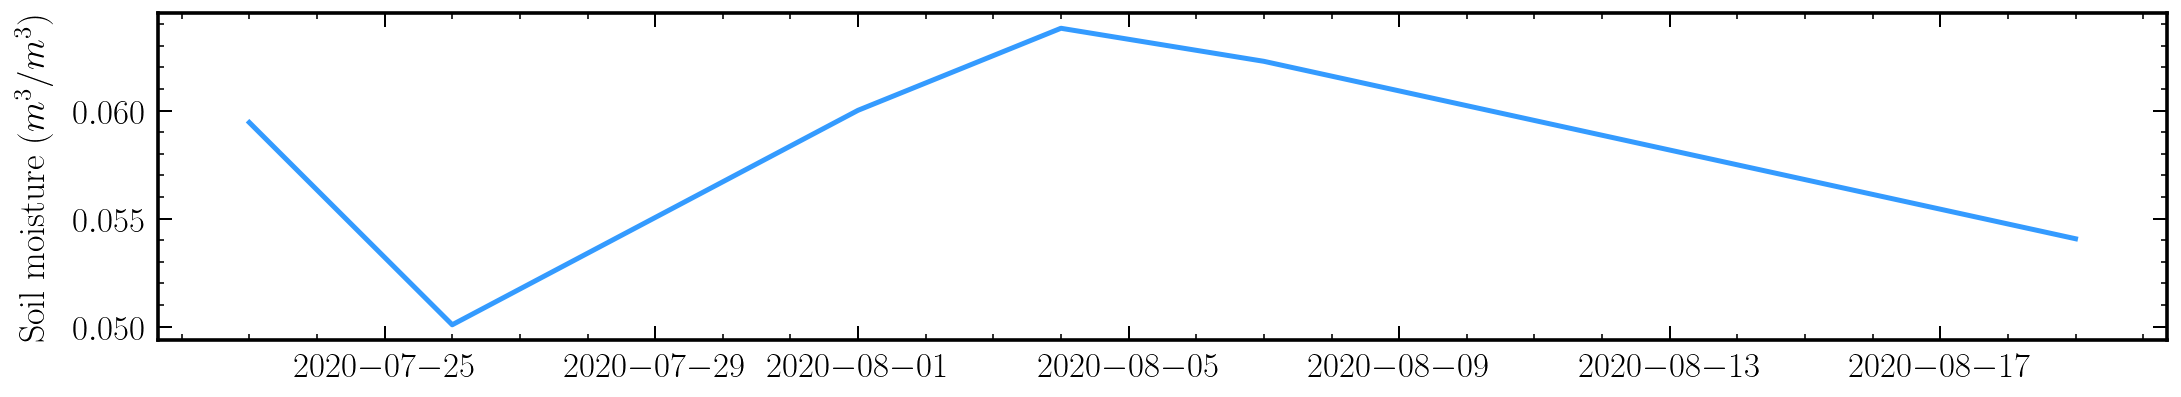

In [267]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
    sm_data.sel(date= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X).interpolate_na(dim= 'date'), color= 'dodgerblue')
ax.set_ylabel(r'Soil moisture ($m^3 /m^3$)', fontsize= 18)
#plt.savefig('../plots/sm_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'Tmax (in C)')

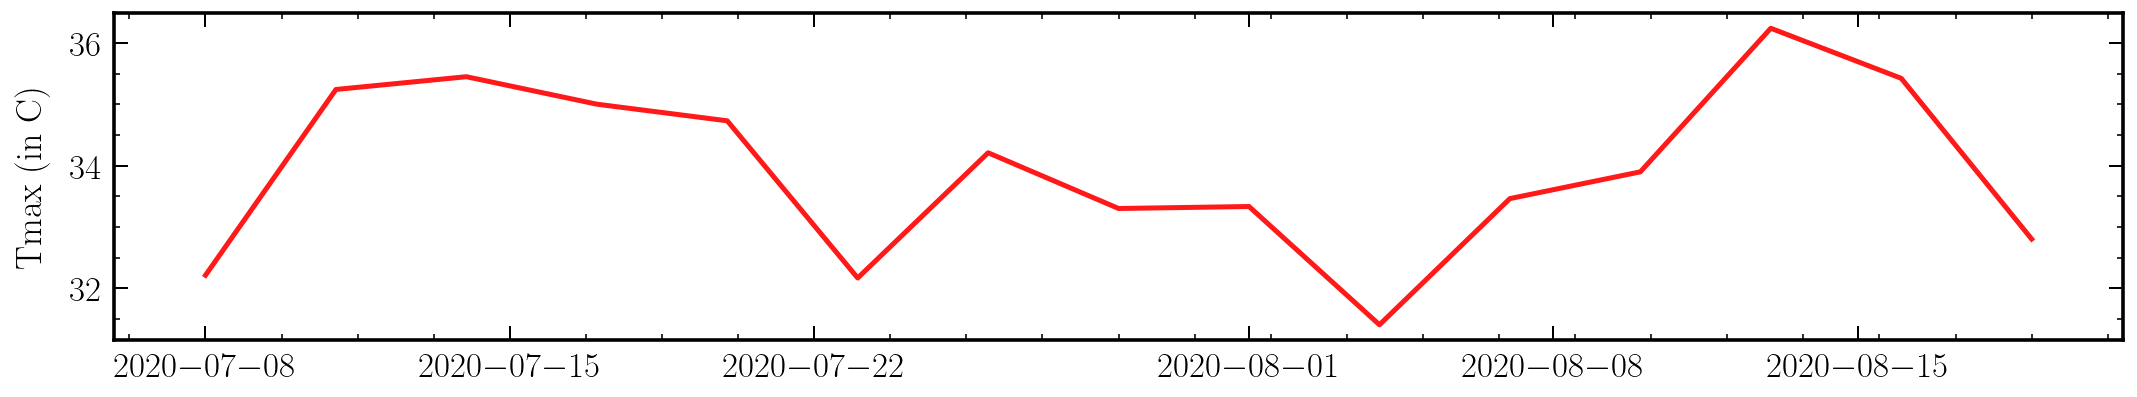

In [251]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
                    tmax_data.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'red')
ax.set_ylabel('Tmax (in C)', fontsize= 18)
#plt.savefig('../plots/tmax_2020.pdf', bbox_inches='tight', dpi= 200);

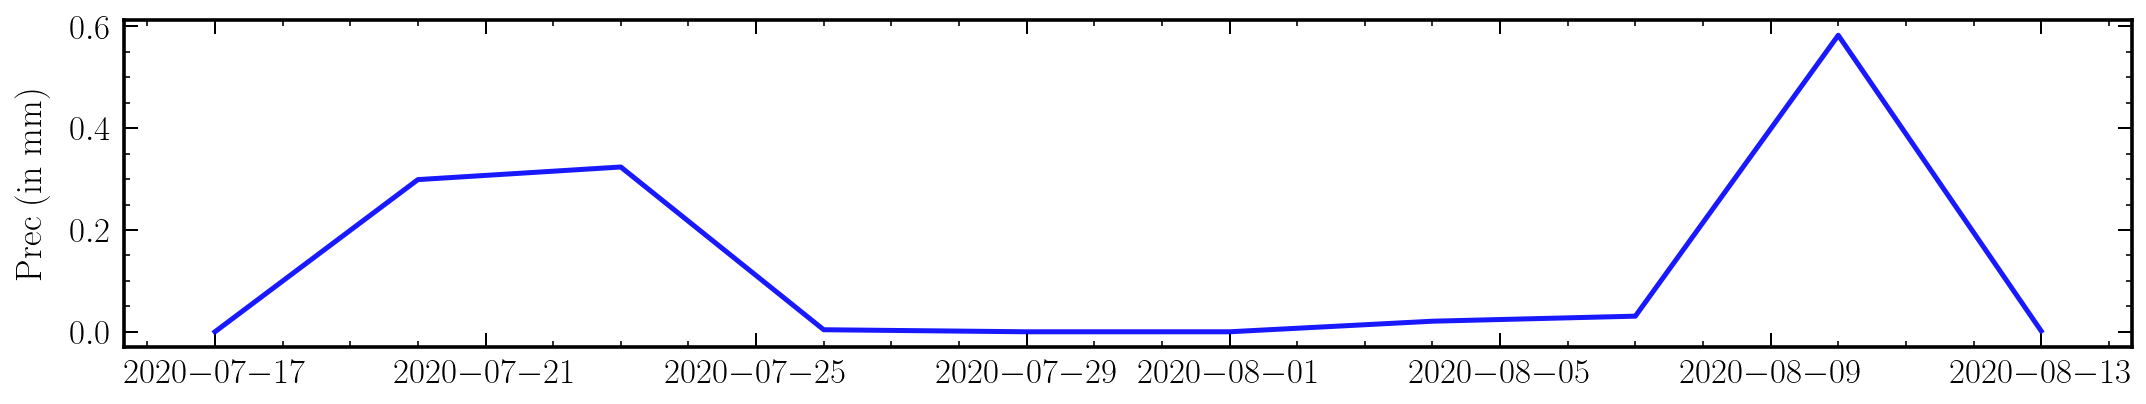

In [218]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), \
                    prec_data.sel(time= pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'blue')
ax.set_ylabel('Prec (in mm)', fontsize= 18)
plt.savefig('../plots/prec_2020.pdf', bbox_inches='tight', dpi= 200);

Text(0, 0.5, 'VPD (in hPa)')

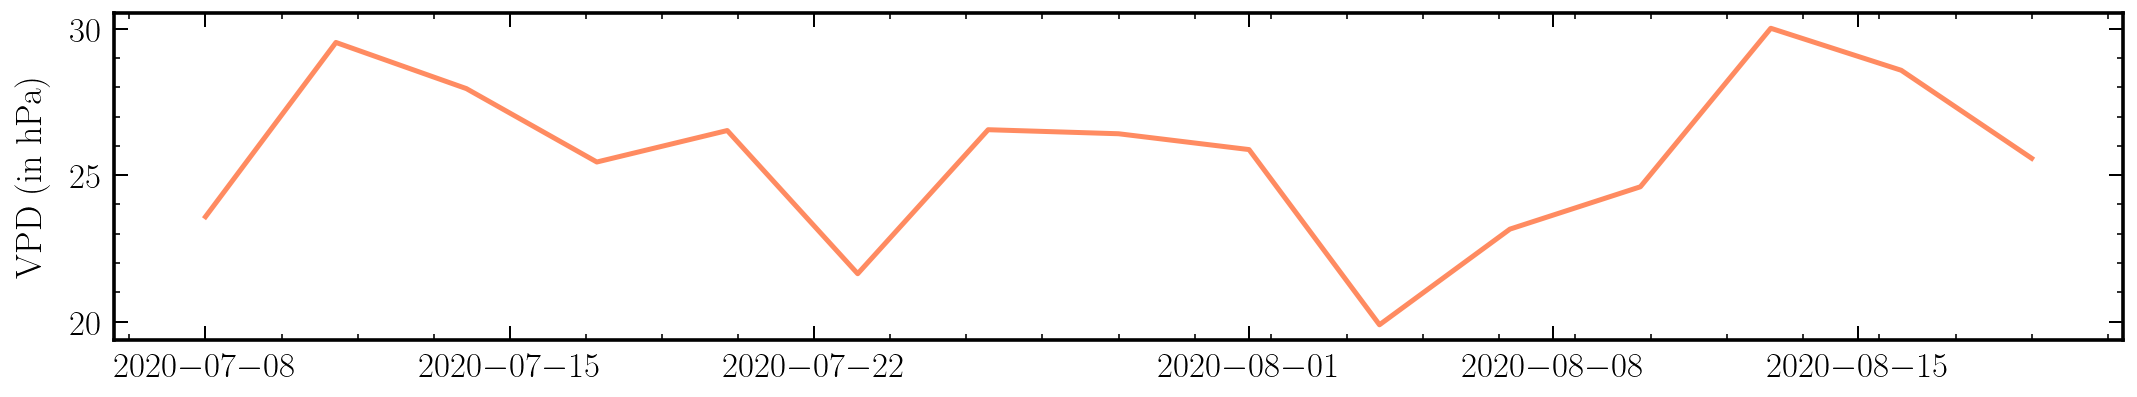

In [252]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), \
                    vpd_data.sel(time= pd.date_range(end= forest_df.loc[ind].time + timedelta(days= 6), periods= 15, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'coral')
ax.set_ylabel('VPD (in hPa)', fontsize= 18)
#plt.savefig('../plots/vpd_2020.pdf', bbox_inches='tight', dpi= 200);

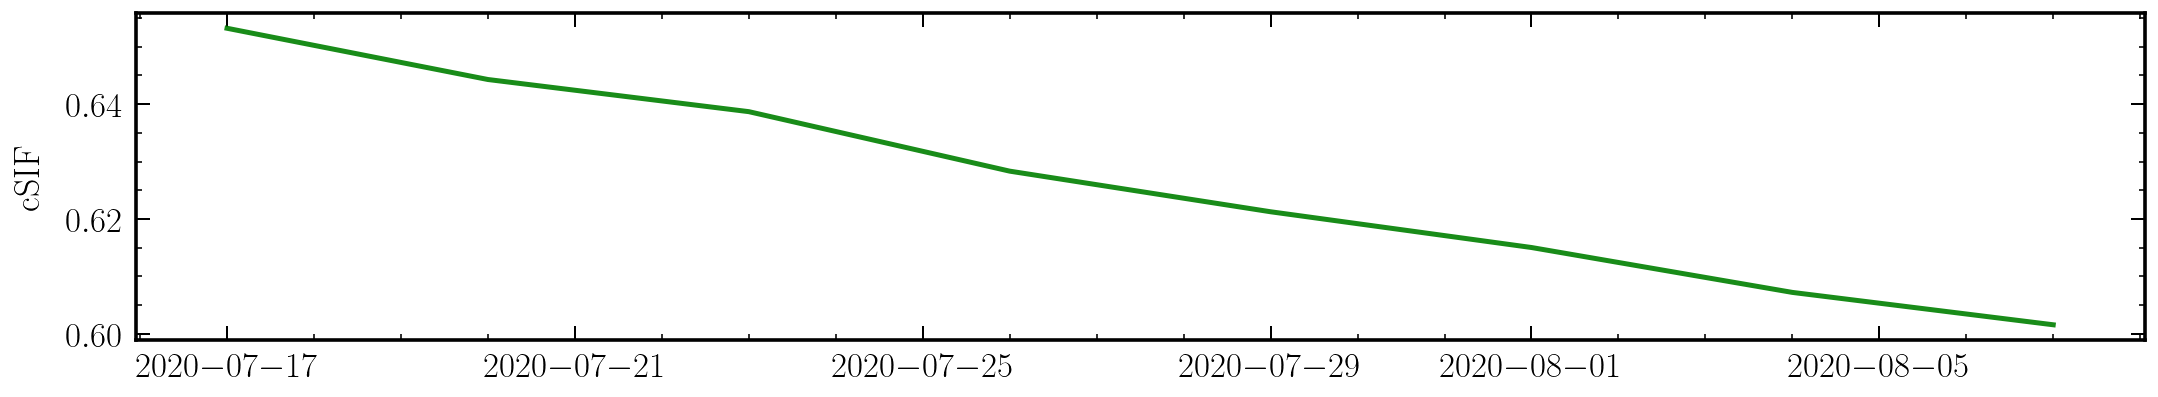

In [216]:
fig, ax= plt.subplots(figsize= (18, 3))
plt.plot(pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), \
                    csif_data.sel(time= pd.date_range(end= forest_df.loc[ind].time, periods= 10, freq= '3D'), Y= forest_df.loc[ind].Y, X= forest_df.loc[ind].X), color= 'green')
ax.set_ylabel('cSIF', fontsize= 18)
plt.savefig('../plots/csif_2020.pdf', bbox_inches='tight', dpi= 200);

### Aggregate statistics